In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/credit-risk-dataset/credit_risk_dataset.csv


# ***Introduction:***

Credit risk assessment is crucial for financial institutions, yet traditional methods like scorecards and logistic regression are limited in handling complex and high-dimensional data. *Machine learning*, especially hybrid models combining supervised and unsupervised techniques, offers a promising solution. This poroject proposes an integrated model using *Kohonen's Self-Organizing Maps (SOM) and Random Forest* to improve the accuracy and reliability of credit risk assessment.

# **Data Description**
**1- Prepare Data**
check data for any missing values, outliers or format problem. As well, we will need to split our data to training data for model building and deployment and test data to assess the model 

In [2]:
#Import libraries

from scipy import stats
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
#Load the dataset

df=pd.read_csv('/kaggle/input/credit-risk-dataset/credit_risk_dataset.csv')

print(df.shape)
print(df.head())

(32581, 12)
   person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      35000          15.23            1   
4     MEDICAL          C      35000          14.27            1   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.59                         Y                   

Feature Name and Description:

* person_age: Age
* person_income: Annual Income
* person_home_ownership: Home ownership
* person_emp_length:	Employment length (in years)
* loan_intent:	Loan intent
* loan_grade: Loan grade
* loan_amnt:	Loan amount
* loan_int_rate	: Interest rate
* loan_status:	Loan status (0 is non default 1 is default)
* loan_percent_income: Percent income
* cb_person_default_on_file	:Historical default
* cb_preson_cred_hist_length:	Credit history length


In [4]:
#Checking and handling missing data
df.info()
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB
person_age                     

Upon checking for missing data, it was found that the columns person_emp_length and loan_int_rate have 895 and 3116 missing values, respectively. To address this issue, we can impute the missing values using either the mean or the median or drop rows that contain the NaN values

In [5]:
df.dropna(inplace=True)
print(df.shape)
print(df.info())

(28638, 12)
<class 'pandas.core.frame.DataFrame'>
Index: 28638 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  28638 non-null  int64  
 1   person_income               28638 non-null  int64  
 2   person_home_ownership       28638 non-null  object 
 3   person_emp_length           28638 non-null  float64
 4   loan_intent                 28638 non-null  object 
 5   loan_grade                  28638 non-null  object 
 6   loan_amnt                   28638 non-null  int64  
 7   loan_int_rate               28638 non-null  float64
 8   loan_status                 28638 non-null  int64  
 9   loan_percent_income         28638 non-null  float64
 10  cb_person_default_on_file   28638 non-null  object 
 11  cb_person_cred_hist_length  28638 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 2.8+ MB
None


In [6]:
#Creating Feature Matrix and Target Vector

X=df.drop(columns="loan_status")
y=df["loan_status"]
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (28638, 11)
y shape: (28638,)


In [7]:
# Splitting data into training data and Test data 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (20046, 11)
y_train shape: (20046,)
X_test shape: (8592, 11)
y_test shape: (8592,)


In [8]:
print(pd.Series(y_train).value_counts())

loan_status
0    15720
1     4326
Name: count, dtype: int64


As we can see, we are facing imbalanced data. To solve this issue, we create a new feature matrix X_train_over and target vector y_train_over by performing random over-sampling on the training data. The main purpose of this step is to balance the dataset so that a machine learning model can be trained more effectively without being biased towards the majority class.


In [9]:
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
print("X_train_over shape:", X_train_over.shape)
X_train_over.head()


X_train_over shape: (31440, 11)


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,36,430000,RENT,2.0,VENTURE,C,25000,13.80,0.06,Y,16
1,30,48000,RENT,1.0,EDUCATION,B,10000,12.18,0.21,N,9
2,24,61400,RENT,1.0,VENTURE,C,12250,12.23,0.20,N,4
3,23,97000,MORTGAGE,5.0,EDUCATION,B,12000,9.91,0.12,N,2
4,43,142500,MORTGAGE,7.0,MEDICAL,B,20000,11.49,0.14,N,15


In [10]:
#Check the balancing again 
print(pd.Series(y_train_over).value_counts())

loan_status
0    15720
1    15720
Name: count, dtype: int64


# **Exploratory Data Analysis (EDA)**

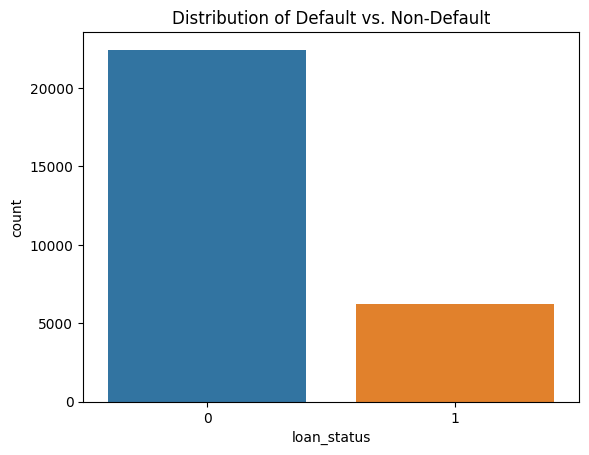

In [11]:
# Visualize the distribution of the target variable
sns.countplot(x='loan_status', data=df)
plt.title('Distribution of Default vs. Non-Default')
plt.show()



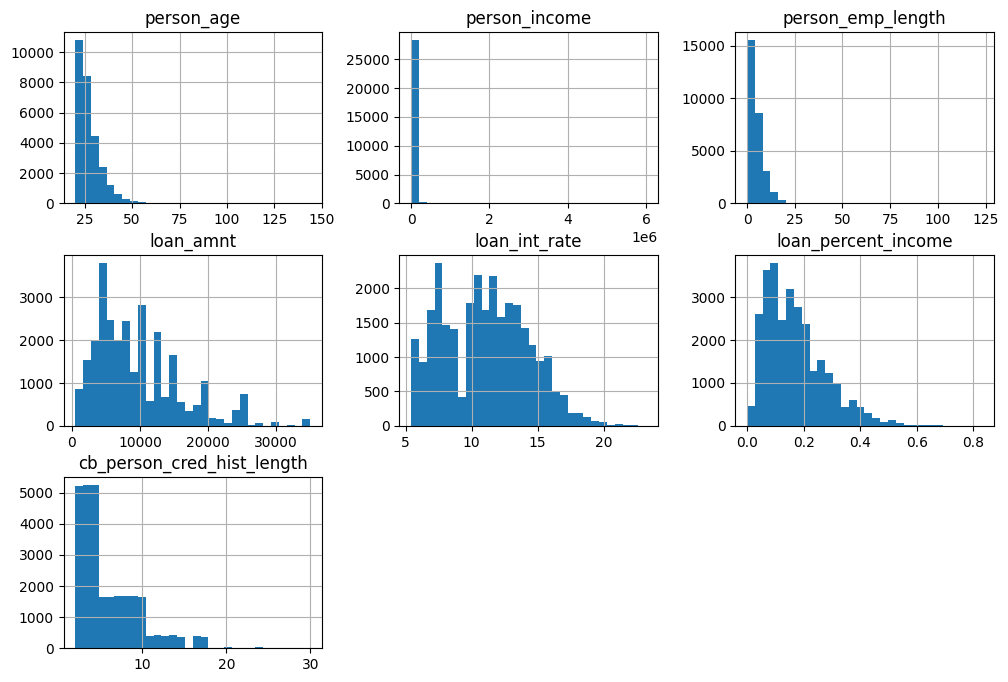

In [12]:

# Visualize feature distributions
X.hist(bins=30, figsize=(12, 8))
plt.show()


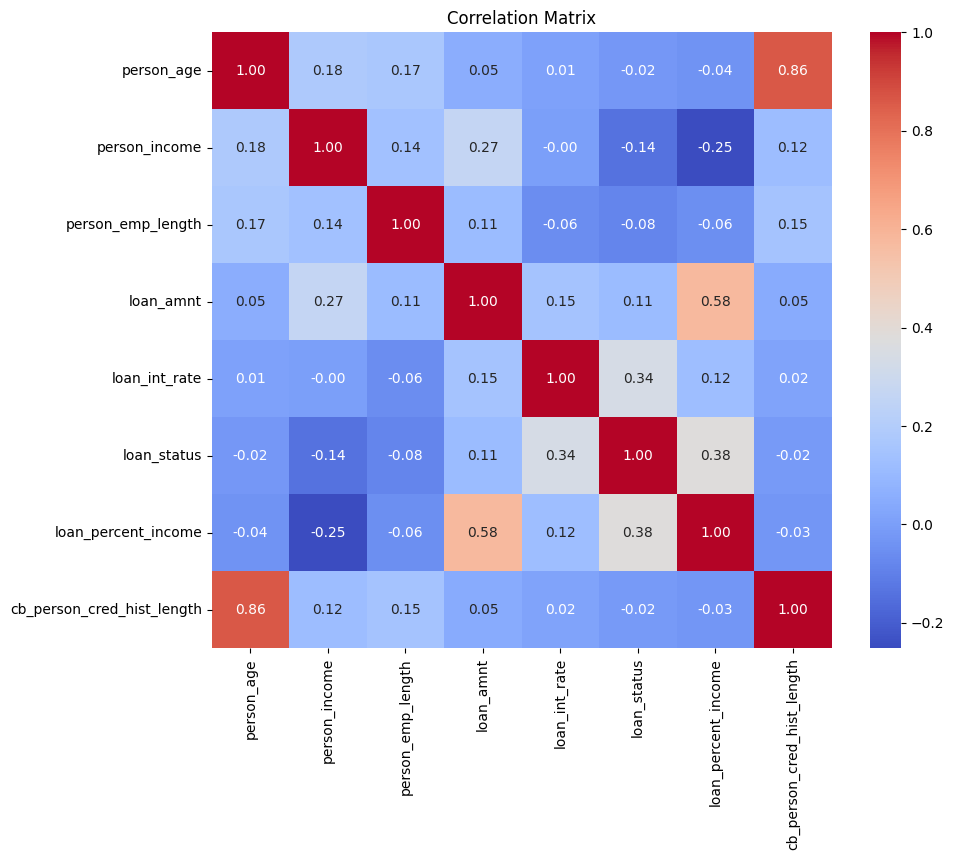

In [13]:
df_numeric = df.select_dtypes(include=['float64', 'int64'])
df_cat= df.select_dtypes(include=["object"])
# Correlation matrix
corr_matrix = df_numeric.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

we see a high correlation between person_age and cb_person_cred_hist_length (credit personal history length) which is normal 

In [14]:
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,28638.000000,2.863800e+04,28638.000000,28638.000000,28638.000000,28638.000000,28638.000000,28638.000000
mean,27.727216,6.664937e+04,4.788672,9656.493121,11.039867,0.216600,0.169488,5.793736
std,6.310441,6.235645e+04,4.154627,6329.683361,3.229372,0.411935,0.106393,4.038483
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.948000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.595600e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,8.000000e+04,7.000000,12500.000000,13.480000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


# **Build Model**
As announced previously, we aim to develop  an  integrated model  combining  Kohonen's  Self-Organizing  Maps (SOM) with the Random Forest algorithm to improve the accuracy and reliability of credit risk assessment. 

Firstly we will run those two types of models separately

 **1-Supervised Model**

Random Forest is an ensemble machine learning algorithm primarily used for classification and regression tasks. It builds multiple decision trees and combines their outputs to improve predictive accuracy and control overfitting.

In [15]:
#Baseline accuracy score for Model
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))


Baseline Accuracy: 0.7842


In [16]:
# Ensure correct column extraction
df_numeric = X_train_over.select_dtypes(include=['float64', 'int64']).columns.tolist()
df_cat = X_train_over.select_dtypes(include=["object"]).columns.tolist()

# Check the columns in X_train_over to make sure they match
print("Numeric columns in X_train_over:", X_train_over.select_dtypes(include=['float64', 'int64']).columns.tolist())
print("Categorical columns in X_train_over:", X_train_over.select_dtypes(include=["object"]).columns.tolist())

# Define the preprocessing pipeline for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), df_numeric),  # Impute missing numerical values with the mean
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing categorical values with the mode
            ('encoder', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode the categorical features
        ]), df_cat)
    ])

# Build Pipeline named clf ("Classifier")
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('randomforestclassifier', RandomForestClassifier(random_state=42))
])
print(clf)

# Create a dictionary with the range of hyperparameters that we want to evaluate for our classifier.
params = {
    "preprocessor__num__strategy": ["mean", "median"],
    "preprocessor__cat__imputer__strategy": ["most_frequent"], 
    "randomforestclassifier__n_estimators": range(25, 100, 25), 
    "randomforestclassifier__max_depth": range(10, 50, 10)
}

# Search over these hyperparameters in order to find the optimal set of hyperparameters that lead to the best model performance.
model = GridSearchCV(
    clf,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1
)

Numeric columns in X_train_over: ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
Categorical columns in X_train_over: ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'loan_percent_income',
                                                   'cb_person_cred_hist_length']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                         

In [17]:
# Train the model
model.fit(X_train_over, y_train_over)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         SimpleImputer(),
                                                                         ['person_age',
                                                                          'person_income',
                                                                          'person_emp_length',
                                                                          'loan_amnt',
                                                                          'loan_int_rate',
                                                                          'loan_percent_income',
                                                                          'cb_person_cred_hist_length']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(hand...
                                                                          'loan_grade',
                                                                          'cb_person_default_on_file'])])),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'preprocessor__cat__imputer__strategy': ['most_frequent'],
                         'preprocessor__num__strategy': ['mean', 'median'],
                         'randomforestclassifier__max_depth': range(10, 50, 10),
                         'randomforestclassifier__n_estimators': range(25, 100, 25)},
             verbose=1)

GridSearchCV is used to automatically search for the best combination of hyperparameters for a machine learning model by exhaustively testing all possible combinations from a specified parameter grid. It evaluates each combination using cross-validation, ensuring the model's performance is robust and generalizes well to unseen data. This process helps optimize the model, improving accuracy and reducing the risk of overfitting.








In [18]:
#the cross-validation result
cv_results = pd.DataFrame(model.cv_results_)
cv_results.head(10)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__cat__imputer__strategy,param_preprocessor__num__strategy,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.915382,0.035052,0.048453,0.001304,most_frequent,mean,10,25,{'preprocessor__cat__imputer__strategy': 'most...,0.872615,0.879135,0.873410,0.871183,0.880089,0.875286,0.003616,21
1,1.573038,0.015989,0.072720,0.001522,most_frequent,mean,10,50,{'preprocessor__cat__imputer__strategy': 'most...,0.871978,0.880884,0.873569,0.871501,0.880725,0.875732,0.004199,19
2,2.320980,0.043292,0.096176,0.000585,most_frequent,mean,10,75,{'preprocessor__cat__imputer__strategy': 'most...,0.873728,0.880566,0.871342,0.870388,0.879453,0.875095,0.004172,23
3,1.148391,0.032429,0.062023,0.004002,most_frequent,mean,20,25,{'preprocessor__cat__imputer__strategy': 'most...,0.974714,0.974714,0.977099,0.979644,0.983779,0.977990,0.003421,17
4,2.153726,0.029073,0.095291,0.002186,most_frequent,mean,20,50,{'preprocessor__cat__imputer__strategy': 'most...,0.976304,0.978053,0.981552,0.982824,0.983779,0.980503,0.002858,15
5,3.076004,0.015757,0.130076,0.003533,most_frequent,mean,20,75,{'preprocessor__cat__imputer__strategy': 'most...,0.975191,0.976940,0.982983,0.982983,0.984733,0.980566,0.003771,13
6,1.136111,0.016895,0.062432,0.003098,most_frequent,mean,30,25,{'preprocessor__cat__imputer__strategy': 'most...,0.978053,0.982347,0.985846,0.986164,0.988073,0.984097,0.003542,9
7,2.203085,0.024071,0.096615,0.001330,most_frequent,mean,30,50,{'preprocessor__cat__imputer__strategy': 'most...,0.982029,0.984733,0.989504,0.988709,0.989822,0.986959,0.003066,5
8,3.552252,0.246918,0.166139,0.060177,most_frequent,mean,30,75,{'preprocessor__cat__imputer__strategy': 'most...,0.981870,0.984574,0.990617,0.988550,0.989822,0.987087,0.003335,1
9,1.211792,0.120848,0.062824,0.003838,most_frequent,mean,40,25,{'preprocessor__cat__imputer__strategy': 'most...,0.978531,0.981870,0.985687,0.985369,0.986641,0.983620,0.003014,11


Text(0.5, 1.0, "['Training Time vs Estimators (Max depth=10)']")

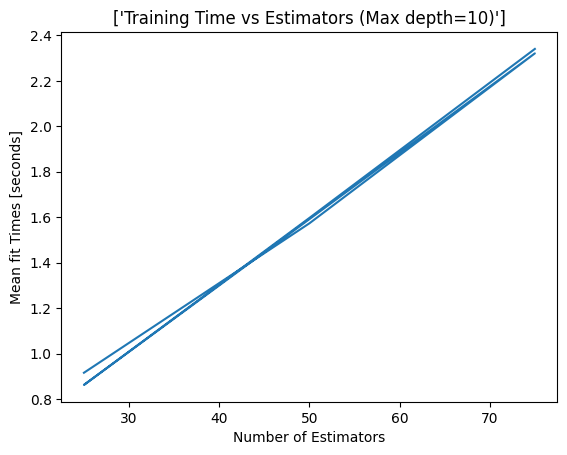

In [19]:
#Create Mask
mask= cv_results["param_randomforestclassifier__max_depth"]==10

#plot fit time vs n_estimators
plt.plot(
    cv_results[mask]["param_randomforestclassifier__n_estimators"],
    cv_results[mask]["mean_fit_time"]
)

#Label Axes
plt.xlabel("Number of Estimators")
plt.ylabel("Mean fit Times [seconds]")
plt.title(["Training Time vs Estimators (Max depth=10)"])

Text(0.5, 1.0, "['Training Time vs Max Depth (n_estimators=25)']")

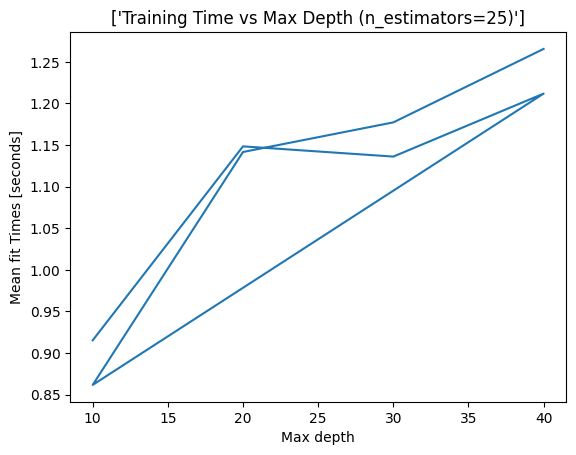

In [20]:
#Create Mask
mask= cv_results["param_randomforestclassifier__n_estimators"]==25

#plot fit time vs n_estimators
plt.plot(
    cv_results[mask]["param_randomforestclassifier__max_depth"],
    cv_results[mask]["mean_fit_time"]
)

#Label Axes
plt.xlabel("Max depth")
plt.ylabel("Mean fit Times [seconds]")
plt.title(["Training Time vs Max Depth (n_estimators=25)"])

In [21]:
# Extract best hyperparameters
model.best_params_


{'preprocessor__cat__imputer__strategy': 'most_frequent',
 'preprocessor__num__strategy': 'mean',
 'randomforestclassifier__max_depth': 30,
 'randomforestclassifier__n_estimators': 75}

**Evaluate The Model**

In [22]:
#Calculate the training and test accuracy scores for model.
acc_train = model.score(X_train_over, y_train_over)
acc_test = model.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 4))
print("Test Accuracy:", round(acc_test, 4))


Training Accuracy: 1.0
Test Accuracy: 0.926


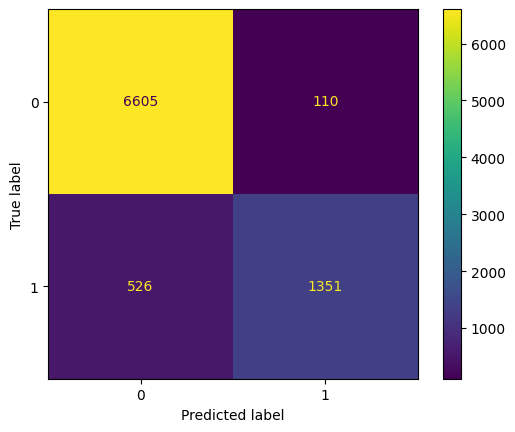

In [23]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test);


In [24]:
#Train predictions
y_pred = model.predict(X_test)
# Print classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.93      0.98      0.95      6715
           1       0.92      0.72      0.81      1877

    accuracy                           0.93      8592
   macro avg       0.93      0.85      0.88      8592
weighted avg       0.93      0.93      0.92      8592



AUC-ROC: 0.9263
AUC-PR: 0.8738


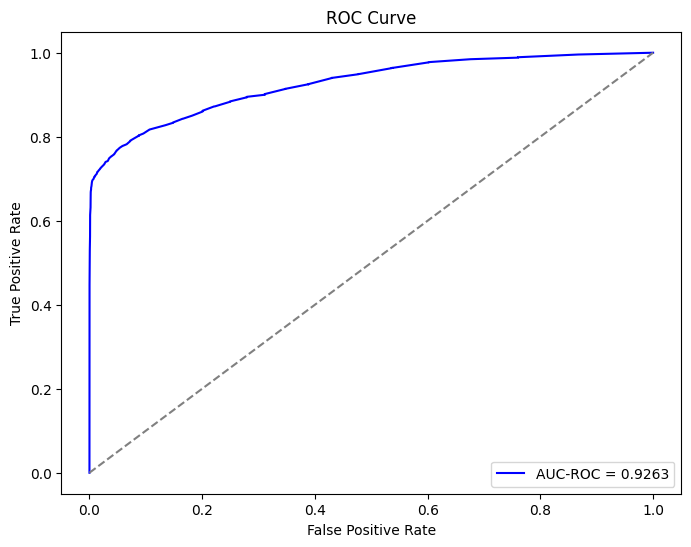

In [25]:
y_prob = model.predict_proba(X_test)[:, 1]

# AUC-ROC
auc_roc = roc_auc_score(y_test, y_prob)
print(f"AUC-ROC: {auc_roc:.4f}")

# AUC-PR (Precision-Recall)
auc_pr = average_precision_score(y_test, y_prob)
print(f"AUC-PR: {auc_pr:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC-ROC = {auc_roc:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()



**2-Unsupervised Model**

Kohonen's Self-Organizing Map (SOM) is an unsupervised machine learning algorithm used for dimensionality reduction, clustering, and data visualization. It is a type of artificial neural network that learns to map high-dimensional data into a lower-dimensional representation  preserving the topological relationships in the data.

In [26]:
df1=df.copy()
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28638 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  28638 non-null  int64  
 1   person_income               28638 non-null  int64  
 2   person_home_ownership       28638 non-null  object 
 3   person_emp_length           28638 non-null  float64
 4   loan_intent                 28638 non-null  object 
 5   loan_grade                  28638 non-null  object 
 6   loan_amnt                   28638 non-null  int64  
 7   loan_int_rate               28638 non-null  float64
 8   loan_status                 28638 non-null  int64  
 9   loan_percent_income         28638 non-null  float64
 10  cb_person_default_on_file   28638 non-null  object 
 11  cb_person_cred_hist_length  28638 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 2.8+ MB


Machine learning algorithms, including the Self-Organizing Map (SOM), typically require numerical data. However, some of your featuresare categorical variables .
So we need to convert these text labels into numerical data, we use Label Encoding, which assigns a unique integer to each category.

In [27]:
# Encode categorical variables
label_encoders = {}
categorical_columns = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
for col in categorical_columns:
    le = LabelEncoder()
    df1[col] = le.fit_transform(df1[col]) 
    label_encoders[col] = le  

Now to numerical data, bringing all features into the same scale, which helps improve the performance and stability of machine learning models.

In [28]:
# 2.3: Normalize numerical features (standard scaling)
scaler = StandardScaler()
numerical_columns = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 
                     'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']

df1[numerical_columns] = scaler.fit_transform(df1[numerical_columns])  

In [29]:
# Prepare features (X) and target variable (y)

X = df1.drop('loan_status', axis=1).values  # Features (drop 'loan_status' from df1)
y = df1['loan_status'].values  # Target variable (loan_status)

In [30]:
#Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

# To verify the balance of loan_status in both training and validation sets
print(f"Training set loan_status distribution:\n{pd.Series(y_train).value_counts(normalize=True)}")
print(f"Validation set loan_status distribution:\n{pd.Series(y_val).value_counts(normalize=True)}")


Training data shape: (20046, 11)
Validation data shape: (8592, 11)
Training set loan_status distribution:
0    0.784196
1    0.215804
Name: proportion, dtype: float64
Validation set loan_status distribution:
0    0.781541
1    0.218459
Name: proportion, dtype: float64


In [31]:
!pip install minisom


  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.3-py3-none-any.whl size=11706 sha256=ca04dd994e1a761633a31d0e6f69cc61e1080eb2244faa0a374d68a2f8c7e7f0
  Stored in directory: /root/.cache/pip/wheels/96/98/a5/52dee3e8ed1dbfc4d77e4da41b6d89dd7ab9ead1b921e766f8
Successfully built minisom


In [32]:
from minisom import MiniSom


In [33]:
#Initialize and train SOM on the training data
som_shape = (10, 10)  # SOM grid dimensions (modifiable)
som = MiniSom(som_shape[0], som_shape[1], X_train.shape[1], sigma=1.0, learning_rate=0.5)


In [34]:
# Initialize weights and train SOM on training data
som.random_weights_init(X_train)
print("Training SOM...")
som.train_random(X_train, num_iteration=1000)  
print("SOM training completed.")

Training SOM...
SOM training completed.


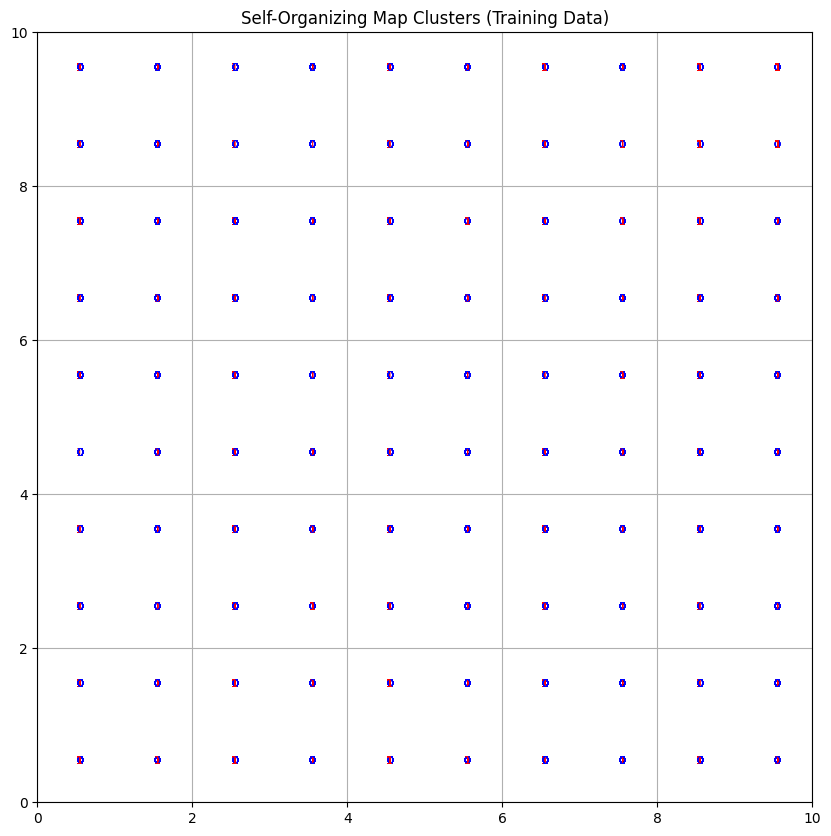

In [35]:
#Visualize the SOM
plt.figure(figsize=(10, 10))
for i, x in enumerate(X_train):
    w = som.winner(x) 
    plt.text(w[0] + 0.5, w[1] + 0.5, str(y_train[i]),
             color='red' if y_train[i] == 1 else 'blue', fontsize=8)

plt.title("Self-Organizing Map Clusters (Training Data)")
plt.xlim([0, som_shape[0]])
plt.ylim([0, som_shape[1]])
plt.grid()
plt.show()

In [36]:
#Assign clusters to the validation data
val_clusters = np.array([som.winner(x) for x in X_val])


In [37]:
#DataFrame with clusters and validation labels
cluster_validation_df = pd.DataFrame({'cluster': [str(cluster) for cluster in val_clusters], 'loan_status': y_val})

In [38]:
cluster_validation_df.head()

,cluster,loan_status
0,[6 4],0
1,[2 1],1
2,[7 0],0
3,[5 2],1
4,[4 0],1


In [39]:
#Evaluate clusters in the validation set
cluster_summary = cluster_validation_df.groupby('cluster')['loan_status'].value_counts(normalize=True).unstack()
print("Cluster Validation Summary:\n", cluster_summary)

Cluster Validation Summary:
 loan_status         0         1
cluster                        
[0 0]        0.798658  0.201342
[0 1]        0.620000  0.380000
[0 2]        0.870968  0.129032
[0 3]        0.920000  0.080000
[0 4]        0.956522  0.043478
...               ...       ...
[9 5]        0.697248  0.302752
[9 6]        0.331361  0.668639
[9 7]        0.568966  0.431034
[9 8]        0.185185  0.814815
[9 9]        0.110092  0.889908

[100 rows x 2 columns]


In [40]:
# Assign the most common loan_status in each cluster as the cluster label
cluster_labels = cluster_validation_df.groupby('cluster')['loan_status'].agg(lambda x: x.value_counts().idxmax())

# Map the cluster labels to the validation data
cluster_validation_df['predicted_status'] = cluster_validation_df['cluster'].map(cluster_labels)


In [41]:
#  actual and predicted labels
y_true = cluster_validation_df['loan_status']
y_pred = cluster_validation_df['predicted_status']

In [42]:
# metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='binary') 
recall = recall_score(y_true, y_pred, average='binary')
f1 = f1_score(y_true, y_pred, average='binary')
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.83
Precision: 0.75
Recall: 0.35
F1 Score: 0.48


In [43]:
probs = cluster_validation_df['cluster'].map(cluster_summary[1]) 
print(probs)

0       0.044872
1       0.579710
2       0.065934
3       0.113924
4       0.421053
          ...   
8587    0.129032
8588    0.873563
8589    0.360465
8590    0.065934
8591    0.151261
Name: cluster, Length: 8592, dtype: float64


In [44]:
overall_default_rate = y_true.mean()
print(overall_default_rate)

0.21845903165735567


In [45]:
# Map cluster probabilities and handle NaNs
probs = cluster_validation_df['cluster'].map(cluster_summary[1])
probs.fillna(overall_default_rate, inplace=True)

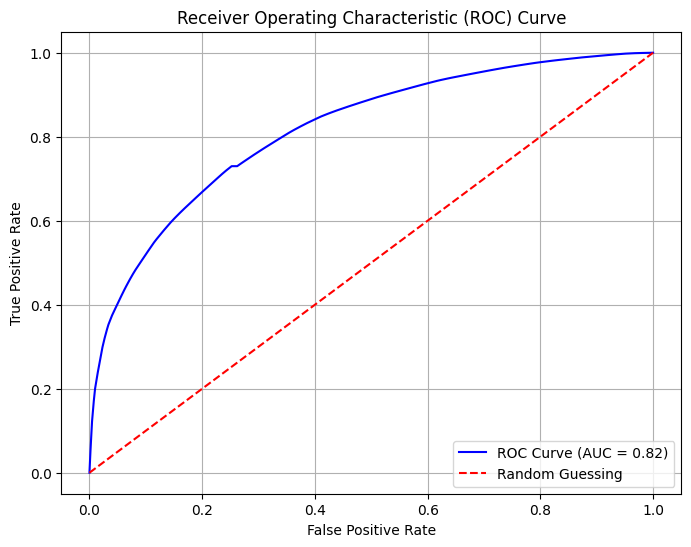

In [46]:
# Calculate FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_true, probs)

# Calculate AUC
auc = roc_auc_score(y_true, probs)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Random Guessing")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()


**Combined Approach of Supervised and Unsupervised Larning**

In [47]:
#Assign SOM clusters
def assign_som_clusters(som, data):
    # Ensure data is a numpy array
    if isinstance(data, pd.DataFrame):
        data = data.to_numpy()
    
    clusters = []
    for row in data:
        winner = som.winner(row)  # Get the winning neuron
        clusters.append(winner[0] * som_shape[1] + winner[1])  # Flatten the grid
    return clusters

In [48]:
feature_columns = df1.drop('loan_status', axis=1).columns.tolist()
X_train = pd.DataFrame(X_train, columns=feature_columns)
X_val = pd.DataFrame(X_val, columns=feature_columns)

# Add SOM cluster labels as a feature
X_train['som_cluster'] = assign_som_clusters(som, X_train)
X_val['som_cluster'] = assign_som_clusters(som, X_val)

In [49]:
#Train Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [50]:
#Predict on validation set
y_pred = rf.predict(X_val)
y_probs = rf.predict_proba(X_val)[:, 1]  # Probabilities for class 1

# Step 10: Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_probs)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"AUC: {auc:.2f}")

Accuracy: 0.93
Precision: 0.96
Recall: 0.69
F1 Score: 0.80
AUC: 0.92


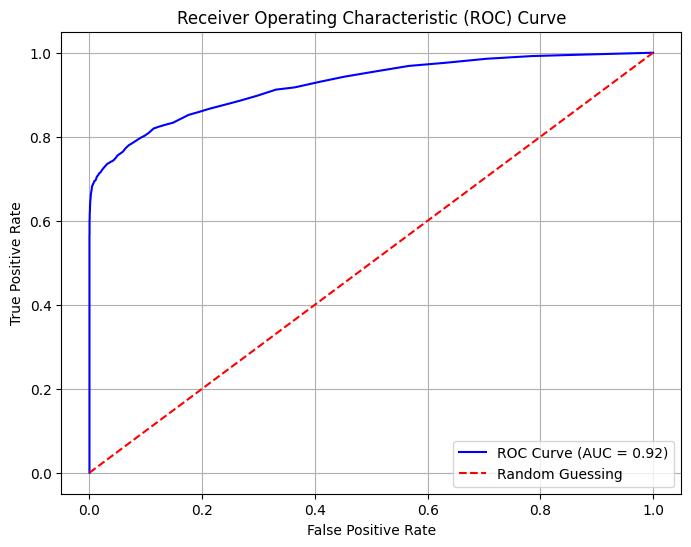

In [51]:
#AUC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Random Guessing")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# **Results**

Performance assessment for diffrent models Recap

**Integrated Model**:
* Accuracy: 0.93
* Precision: 0.96
* Recall: 0.69
* F1 Score: 0.80
* AUC: 0.93

**Unsupervised Model**

* Accuracy: 0.83
* Precision: 0.68
* Recall: 0.43
* F1 Score: 0.53
* AUC: 0.83

**Supervised Model**              

* Accuracy: 0.926
* Precision: 0.93
* Recall: 0.93
* F1 Score: 0.92 
* AUC: 0.9263

**Interpretation and Comparison**

* Integrated Model (SOM + Random Forest): This model leverages the strengths of both unsupervised and supervised learning. It performs exceptionally well with high accuracy, precision, and AUC. However, the lower recall suggests that while it is excellent at identifying non-defaults, it could still miss some defaults.

* Unsupervised Model (SOM): The unsupervised model struggles with both precision and recall, highlighting the challenges of using a purely unsupervised approach for a classification problem like predicting loan defaults. It misses a significant portion of actual defaults and has a higher rate of false positives.

* Supervised Model (Random Forest): The supervised Random Forest model strikes a strong balance between precision, recall, and F1 score. It has higher recall and similar precision compared to the integrated model. While its performance is very good, it is slightly outperformed by the integrated model, likely due to the added information from the SOM features.

Risk of Overfitting
For the supervised model, the risk of overfitting is present. However, based on the metrics (e.g., high AUC, balanced precision, and recall), the model appears to generalize well. It’s important to continue validating the model on unseen data and apply regularization techniques like limiting tree depth and increasing minimum samples per leaf to avoid overfitting.



# **Conclusion**

Best Model for Default Prediction: The Integrated Model (SOM + Random Forest) provides the best overall performance in terms of accuracy, precision, and AUC. However, improvements can still be made in recall to reduce missed defaults.

Model Selection: 
* If we prioritize catching as many defaults as possible, the Supervised Random Forest model, with its higher recall, may be a better choice. 
* If we want to maintain a good balance between performance metrics and reduce false positives, the Integrated Model may be preferred.

In either case, continual refinement, tuning, and monitoring will be important to ensure that the models perform optimally as new data becomes available.